In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import root_mean_squared_error

In [175]:
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNetCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [176]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
holiday_events=pd.read_csv("data/holidays_events.csv")
oil=pd.read_csv("data/oil.csv")
stores=pd.read_csv("data/stores.csv")

# Kennelernen des Datasets
## train.csv

In [177]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [178]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In der Tabelle der Trainingsdaten sind schon einige interessante features für die Voraussage der Sales vorhanden. Schauen wir uns einmal die übrigen Tabellen an, um eventuell weitere relevante Informationen in das Modell mit einzubeziehen.

## oil.csv
Diese Tabelle hat Informationen über die Ölpreise gespeichert. Diese Informationen könnten nützlich sein, da Ecuadors Wirtschaft stark abhängig von den Ölpreisen ist.

In [179]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [180]:
train=pd.merge(train,oil, on="date", how="left")
test=pd.merge(test,oil, on="date", how="left")

In [181]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN


## stores.csv
Diese Tabelle speichert Informationen über die Stores, wie die Standorte oder sogar eine Typisierung mittels Clustering.

In [182]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [183]:
train=pd.merge(train,stores, on="store_nbr", how="left")
test=pd.merge(test,stores, on="store_nbr", how="left")

In [184]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13


## holiday_events.csv
Letztlich werfen wir ein Blick auf die Tabelle Holiday Events, welche die Feiertage in Ecuador festhält.

In [185]:
holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


Der Einfachheit wegen, begrenzen wir uns ausschließlich auf nationale Feiertage. 

In [186]:
national_holidays=holiday_events[(holiday_events["locale"]=="National")&(holiday_events["type"]=="Holiday")]

In [187]:
national_holidays = national_holidays[~national_holidays['description'].str.startswith('Terremoto')]
national_holidays = national_holidays[~national_holidays['description'].str.startswith('Mundial de futbol')]

In [188]:
national_holidays.head()

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False


In [189]:
train=pd.merge(train, national_holidays, on="date", how="left")
test=pd.merge(test, national_holidays, on="date", how="left")

In [190]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [191]:
#Löschen irrelevanter Spalten
train=train.drop(["type_y","locale","locale_name","transferred"], axis=1)

In [192]:
#Umbenennen der Spalten in passendere Namen
train["oil_price"]=train["dcoilwtico"]
train["holiday"]=train["description"]
train=train.drop(["dcoilwtico", "id", "city"], axis=1)

test["oil_price"]=test["dcoilwtico"]
test["holiday"]=test["description"]
test=test.drop(["dcoilwtico", "id", "city", "description"], axis=1)

In [193]:
train["date"]=pd.to_datetime(train["date"])
train["year"]=train["date"].dt.year
train["month"]=train["date"].dt.month
train.set_index("date", inplace=True, drop=True)

In [194]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
 4   state        object 
 5   type_x       object 
 6   cluster      int64  
 7   description  object 
 8   oil_price    float64
 9   holiday      object 
 10  year         int32  
 11  month        int32  
dtypes: float64(2), int32(2), int64(3), object(5)
memory usage: 274.7+ MB


In [195]:
train.head()

,store_nbr,family,sales,onpromotion,state,type_x,cluster,description,oil_price,holiday,year,month
date,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Pichincha,D,13,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,1,BABY CARE,0.0,0,Pichincha,D,13,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,1,BEAUTY,0.0,0,Pichincha,D,13,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,1,BEVERAGES,0.0,0,Pichincha,D,13,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,1,BOOKS,0.0,0,Pichincha,D,13,Primer dia del ano,NaN,Primer dia del ano,2013,1


# Basic Data Exploration

In [196]:
train = train[train['sales']!=0]

In [197]:
train["sales"].describe()

count    2.061758e+06
mean     5.207425e+02
std      1.297187e+03
min      1.220000e-01
25%      9.000000e+00
50%      7.846250e+01
75%      3.880000e+02
max      1.247170e+05
Name: sales, dtype: float64

In [198]:
correlation=train.corr(numeric_only=True)

In [199]:
correlation["sales"].sort_values(ascending=False)

sales          1.000000
onpromotion    0.410608
store_nbr      0.061742
cluster        0.038872
year           0.028285
month          0.012308
oil_price     -0.030120
Name: sales, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

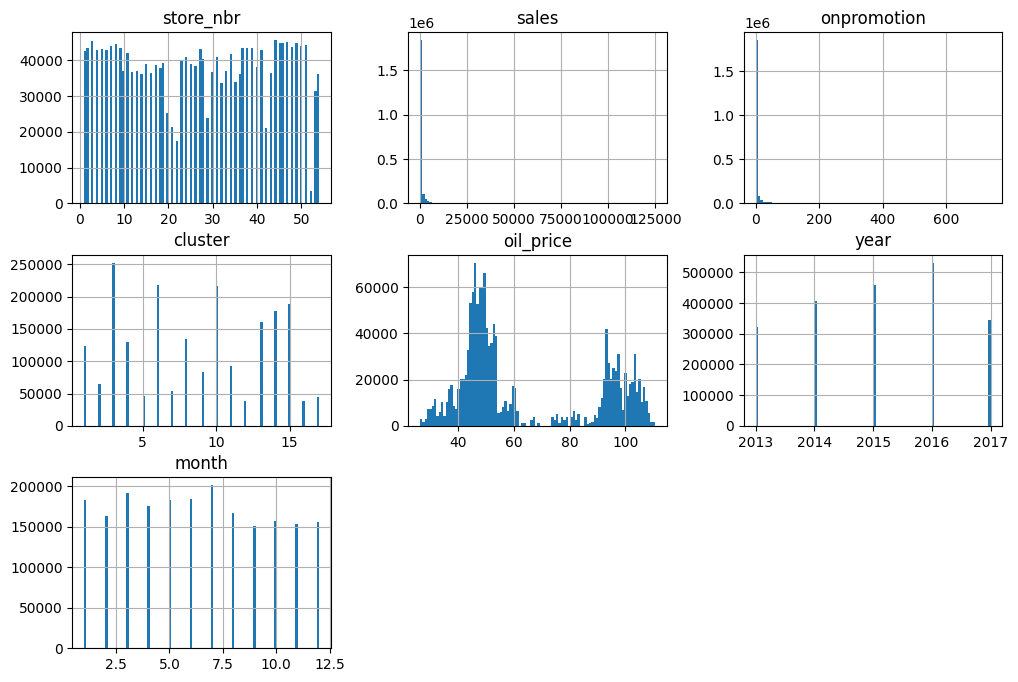

In [200]:
train.hist(bins=100, figsize=(12,8))
plt.show

Dieser Plot zeigt, dass es überverhältnismäßig viele Datensätze gibt, bei denen sales = 0 ist. Diese Beobachtung könnte sich durch 2 Gründe erklären lassen.
(1) Stores werden auch aufgeführt, bevor sie eröffnet haben.
(2) Es gibt Stores, welche verschiedene Produktfamilien überhaupt nicht anbieten.

# Data-Splitting

In [201]:
# 'new' data as validation set
validation_set=test 
# original training set is split into train and test data, each store type is equally represented
train_set, test_set= np.split(train, [int(.8 *len(train))])

/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [202]:
training_features = train_set.drop("sales", axis=1)
training_labels = train_set["sales"].copy()

testing_features = test_set.drop("sales", axis=1)
testing_labels = test_set["sales"].copy()

training_features=training_features[:200000]
training_labels= training_labels[:200000]

testing_features=testing_features[:40000]
testing_labels= testing_labels[:40000]


In [203]:
training_features.head()

,store_nbr,family,onpromotion,state,type_x,cluster,description,oil_price,holiday,year,month
date,,,,,,,,,,,
2013-01-01,25,BEAUTY,0,Santa Elena,D,1,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,25,BEVERAGES,0,Santa Elena,D,1,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,25,BREAD/BAKERY,0,Santa Elena,D,1,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,25,CLEANING,0,Santa Elena,D,1,Primer dia del ano,NaN,Primer dia del ano,2013,1
2013-01-01,25,DAIRY,0,Santa Elena,D,1,Primer dia del ano,NaN,Primer dia del ano,2013,1


# Preprocessing
Hier werden NaN Values entfernt, Daten skaliert und Datentypen so transformiert, dass ML-Algorithmen damit arbeiten können.

In [204]:
poly_cat_pipe=Pipeline([("Imputer", SimpleImputer(strategy="most_frequent")),
                    ("Encoder", OneHotEncoder(handle_unknown="ignore")),
                    ("Poly", PolynomialFeatures(degree=3, include_bias=False))]
                 )
poly_holiday_pipe=Pipeline([("Imputer", SimpleImputer(fill_value="no holiday", strategy='constant')),
                      ("Encoder", OneHotEncoder(handle_unknown="ignore")),
                      ("Poly", PolynomialFeatures(degree=3, include_bias=False))]
                     )
poly_num_pipe=Pipeline([("Imputer", SimpleImputer(strategy="mean")),
                   ("Poly", PolynomialFeatures(degree=3, include_bias=False)),
                   ("Scaler", StandardScaler())]
                 )

cat_pipe=Pipeline([("Imputer", SimpleImputer(strategy="most_frequent")),
                      ("Encoder", OneHotEncoder(handle_unknown="ignore"))]
                     )
holiday_pipe=Pipeline([("Imputer", SimpleImputer(fill_value="no holiday", strategy='constant')),
                      ("Encoder", OneHotEncoder(handle_unknown="ignore"))]
                     )
num_pipe=Pipeline([("Imputer", SimpleImputer(strategy="mean")),
                      ("Scaler", StandardScaler())]
                     )


In [205]:
preprocessing= ColumnTransformer([
    ("holiday", holiday_pipe, make_column_selector(pattern="holiday")),
    ("cat", cat_pipe, make_column_selector(dtype_include=object)),
    ], remainder=num_pipe)

poly_pre=ColumnTransformer([
           ("holiday", "drop", make_column_selector(pattern="holiday")),
            ("cat", "drop", make_column_selector(dtype_include=object))
            ], remainder= poly_num_pipe)


# Model Vorauswahl

In [206]:
#creating models
rf_model = RandomForestRegressor(random_state=42, max_depth=5)
dt_model = DecisionTreeRegressor(random_state=42, max_depth=3)
ridge_sgd_model = RidgeCV()
ridge_poly_model = RidgeCV()

models={'Decision Tree Model':dt_model,  ' Ridge SGD Regressor': ridge_sgd_model, 'Ridge Poly Model' : ridge_poly_model, 'Random Forest Regressor':rf_model}


In [207]:
for name, model in models.items():

    if name in ("Ridge Poly Model", "Elastic Net Poly Model"):
        model_pipe=make_pipeline( poly_pre, model)        
    else:
        model_pipe=make_pipeline(preprocessing, model)
        
    model_pipe.fit(training_features, training_labels)
    rmse_train=root_mean_squared_error(training_labels, model_pipe.predict(training_features))
    rmse_test=root_mean_squared_error(testing_labels, model_pipe.predict(testing_features))
    print(f"Root-Mean-Squared-Error on Training Data/Testing Data of the {name} is {rmse_train:.2f}/ {rmse_test:.2f}")

Root-Mean-Squared-Error on Training Data/Testing Data of the Decision Tree Model is 454.03/ 1130.24
Root-Mean-Squared-Error on Training Data/Testing Data of the  Ridge SGD Regressor is 515.56/ 1194.76
Root-Mean-Squared-Error on Training Data/Testing Data of the Ridge Poly Model is 925.03/ 5705.21
Root-Mean-Squared-Error on Training Data/Testing Data of the Random Forest Regressor is 354.00/ 1093.03


In [208]:
candidate_model=Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(max_depth=5, random_state=42))
     ])

In [209]:
candidate_rmses=-cross_val_score(candidate_model, testing_features, testing_labels, scoring="neg_root_mean_squared_error", cv=3)
pd.Series(candidate_rmses).describe()

/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['description' 'holiday']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['description' 'holiday']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/h

count      3.000000
mean     683.468431
std      104.495247
min      563.403477
25%      648.266589
50%      733.129701
75%      743.500907
max      753.872113
dtype: float64

In [210]:
final_model=Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(max_depth=15, n_estimators=146, max_features=53, random_state=42))
     ])

In [ ]:
forest_rmses=-cross_val_score(final_model, testing_features, testing_labels, scoring="neg_root_mean_squared_error", cv=3)
pd.Series(forest_rmses).describe()

/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/home/niklas/.cache/pypoetry/virtualenvs/ml-projects-uLAoRIfS-py3.12/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['description' 'holiday']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
